<a href="http://www.stfc.ac.uk/"> <img src="../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# Data preparation
-------------------------------
We will cover the following topics in this session.

* Large number of features, how to approach them.
* Transforming data - e.g. normalisation
* Multi dimensional scaling, etc.
* Train, validation, test sets
* Validation approaches - cross validation, leave one out.


In [2]:
#import statements
import sys
sys.path.append("../lib/")
import models
import sklearn
import pandas
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

models.hideAnswers

Imported models functions


In [3]:
#load data for this module
training_data = pandas.read_pickle("../model_data/chembl21_drug_easy_train_desc.p")
training_data.head()

BalabanJ      BertzCT       Chi0      Chi0n      Chi0v       Chi1  \
0  0.000000e+00    30.629190   3.577350   3.316497   5.316497   1.732051   
1  0.000000e+00   122.240916   8.198671   7.086172   7.902669   4.416502   
2  3.360000e-07   352.958551  11.897341   8.367731   9.184227   6.787694   
3  2.889998e-06   349.758919  12.673362  10.978889  11.795385   8.168234   
4  1.495963e-06  2226.506876  45.166715  36.872730  31.689226  27.432255   

       Chi1n      Chi1v      Chi2n      Chi2v   ...     fr_sulfide  \
0   0.908248   0.908248   0.491582   0.491582   ...              0   
1   3.104792   3.104792   3.149850   3.149850   ...              0   
2   4.281651   5.678614   3.114840   4.010507   ...              0   
3   6.030617   6.030617   3.904792   3.904792   ...              0   
4  20.404662  19.252973  14.169512  15.635552   ...              0   

   fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  \
0             0           0                  0             0            0   
1             0           0                  0             0            0   
2             0           0                  0             0            0   
3             0           0                  0             0            0   
4             0           0                  0             0            0   

   fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0             0                 0        0  
1            0             0                 0        0  
2            0             0                 0        0  
3            0             0                 0        0  
4            0             0                 0        0  

[5 rows x 198 columns]

## Sparse data

In machine learning, you will find that data can be sparse, that is containing lots of empty values. An example would be for product sales data (e.g. christmas tree), in which during most weeks of the year, there would be no data (no sales).

There are a few ways to deal with this sort of problem:
* Convert to dense data - look at only the data that is relevant to the problem, e.g. the christmas period and the run up to.
* Data imputation, replace the missing values with an informative value. There are no sales for the remainder of the year, so set missing sales values to 0.

It is likely with our own molecule descriptors dataset that some descriptors are going to be sparse, and in our dataset, if a descriptor is not present, it has been given the value 0. The fragment descriptors are a great example of this.

For example, 'fr_sulfide', the count of sulfides (S2-) in a molecule. Not all molecules will contain sulfide, but few may, so this feature is likely to be sparse. Therefore, if no sulfide is present, the entry has been set to 0.

In [4]:
#gather a list of descriptors using the dataframe column names
descriptors = training_data.columns.tolist()
#using list comprehension, select all descriptors in the list that contain 'fr_' (is a fragment descriptor)
fragment_descriptors = [d for d in descriptors if 'fr_' in d]
#select columns in dataframe that are fragment_descriptors, see the first 5 entries
training_data[fragment_descriptors].head()

fr_Al_COO  fr_Al_OH  fr_Al_OH_noTert  fr_ArN  fr_Ar_COO  fr_Ar_N  fr_Ar_NH  \
0          1         0                0       0          0        0         0   
1          0         0                0       0          0        0         0   
2          0         0                0       0          0        0         0   
3          0         0                0       1          0        0         0   
4          0         4                3       0          0        1         0   

   fr_Ar_OH  fr_COO  fr_COO2   ...     fr_sulfide  fr_sulfonamd  fr_sulfone  \
0         0       1        1   ...              0             0           0   
1         0       0        0   ...              0             0           0   
2         0       0        0   ...              0             0           0   
3         0       0        0   ...              0             0           0   
4         0       0        0   ...              0             0           0   

   fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                  0             0            0            0             0   
1                  0             0            0            0             0   
2                  0             0            0            0             0   
3                  0             0            0            0             0   
4                  0             0            0            0             0   

   fr_unbrch_alkane  fr_urea  
0                 0        0  
1                 0        0  
2                 0        0  
3                 0        0  
4                 0        0  

[5 rows x 85 columns]

In [8]:
#if fr_sulfide == 0, there is no sulfide in the molecule. Check the number of molecules that do not and do have sulfides
has_sulfide = len(training_data[training_data['fr_sulfide'] > 0])
no_sulfide = len(training_data[training_data['fr_sulfide'] == 0])

#calculate proportion
print("%0.2f%% of the data has a non-zero value for 'fr_sulfide'" %((has_sulfide/len(training_data))*100))

6.99% of the data has a non-zero value for 'fr_sulfide'


We should therefore check that only features with some non-zero values are in the data, removing any features where the value is all the same (therefore not giving any information to the modelling approach).

Pandas allows us to check for any null values, and any 0 values.

In [10]:
#any descriptor values that are not equal to 0., axis=0 means to look in a column by column basis
descriptors_with_values = (training_data != 0).any(axis=0)
#this returns a True/False for each descriptor, detailing whether the descriptor any non-zero values

#using the true/false, select only those descriptors (and all entries) that have any nonzero values
training_data_with_nonzero_values = training_data.loc[:,descriptors_with_values]

#compare the change in the number of columns
print("Removed:\n %s" %(set(training_data.columns) - set(training_data_with_nonzero_values.columns)))

Removed:
 {'VSA_EState7', 'VSA_EState4', 'fr_isocyan', 'VSA_EState6', 'fr_prisulfonamd', 'fr_thiocyan', 'VSA_EState2', 'fr_alkyl_carbamate', 'VSA_EState3', 'fr_barbitur', 'VSA_EState1', 'SlogP_VSA9', 'SMR_VSA8'}


In [11]:
#We can also check for any null columns, again we use axis=1 to indicate columns
training_data = training_data_with_nonzero_values.dropna(axis=1)
#see the first 5 entries
training_data.head()

BalabanJ      BertzCT       Chi0      Chi0n      Chi0v       Chi1  \
0  0.000000e+00    30.629190   3.577350   3.316497   5.316497   1.732051   
1  0.000000e+00   122.240916   8.198671   7.086172   7.902669   4.416502   
2  3.360000e-07   352.958551  11.897341   8.367731   9.184227   6.787694   
3  2.889998e-06   349.758919  12.673362  10.978889  11.795385   8.168234   
4  1.495963e-06  2226.506876  45.166715  36.872730  31.689226  27.432255   

       Chi1n      Chi1v      Chi2n      Chi2v   ...     fr_quatN  fr_sulfide  \
0   0.908248   0.908248   0.491582   0.491582   ...            0           0   
1   3.104792   3.104792   3.149850   3.149850   ...            1           0   
2   4.281651   5.678614   3.114840   4.010507   ...            0           0   
3   6.030617   6.030617   3.904792   3.904792   ...            0           0   
4  20.404662  19.252973  14.169512  15.635552   ...            0           0   

   fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  \
0             0           0                  0             0            0   
1             0           0                  0             0            0   
2             0           0                  0             0            0   
3             0           0                  0             0            0   
4             0           0                  0             0            0   

   fr_thiophene  fr_unbrch_alkane  fr_urea  
0             0                 0        0  
1             0                 0        0  
2             0                 0        0  
3             0                 0        0  
4             0                 0        0  

[5 rows x 185 columns]

## Large number of features

Another issue may be with the number of features involved in the dataset. There are a few questions to consider here:
    
1. Are all features relevant to the modelling question asked?
2. Are any features related?
3. Can the features be transformed in some way to reduce dimensionality?

Some comments to illustrate these questions:
    
### 1. Are all features relevant to the modelling question asked?
 
In a modelling attempt at guessing height from someones gender, the training dataset included the following features:
* Colour of top
* Gender

It just so happens that a lot of the training data was gathered from males wearing navy tops. A model trained on just gender would not be a good model for height, however, if a model outperforms this, it may be fitting to the colour of the top instead. Using this feature could end up misleading the audience that height can be determined by gender. 

An example of this is in [tactical aviation modelling](https://dl.acm.org/citation.cfm?doid=800257.808903).

### 2. Are any features related?

Some features may be related to another and therefore give no extra information to the model. For example, if one were to model the height of a river, with the rainfall in cm and the rainfall in inches as features, it is clear that the two features are related, and give identical information to the model. In such instances, one of the duplicate features should be removed.

This sort of curating will require some prior knowledge about the field, particularly in cheminformatics. 

<div class="alert alert-warning" role="alert">
<b>Question:</b> Could there be any RDKit descriptors that give the same information?</div>

To find what each descriptor means, click [here](http://www.rdkit.org/Python_Docs/rdkit.Chem.Descriptors-module.html).


In [13]:
#gather a list of the descriptors
training_data.columns.tolist()

['BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'ExactMolWt',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'FractionAromaticAtom',
 'FractionAromaticValenceElectrons',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomCount',
 'HeavyAtomMolWt',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'MolLogP',
 'MolMR',
 'MolWt',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRadicalElectrons',
 'NumRotatableBonds',
 'NumSaturatedCarb

Although there does seem to be some related features, the relationship may not necessarily be immediate, an example:
    
* <i>FractionAromaticAtom and FractionAromaticValenceElectrons</i><br>
    These were features we have calculated ourselves, and indicates the proportion of the molecules atoms that are aromatic, whilst fraction aromatic valence electrons indicates the proportion of the molecules valence electrons that are aromatic. Whilst we can expect that the fraction of aromatic valence electrons would increase if the fraction of aromatic atoms were to increase, this would depend on the size of the aromatic atom (not all atoms have the same number of valence electrons).
* <i>HeavyAtomCount and HeavyAtomMolWt</i><br>
    Similar to the argument above, although these may be related, a single change in HeavyAtomCount is not replicated in a change in HeavyAtomMolWt, which whilst it would increase when a heavy atom (non-H) is added to the molecule, the molecular weight is dependent upon the size of the atom added.
    
In summary, there are likely to be many features dependent upon other features, but as we do not know which of these features play a role in predicting (for example), drug-likeness of a molecule, we cannot make a decision on which features to remove.

Instead, we could look at the amount of information shared between features, and try and identify if a group of features give the same amount of information to a model.

## 3. Can the features be transformed in some way to reduce dimensionality? 

If we have little prior knowledge about related features, dimensionality reduction can be a good method to help us identifiy information shared amongst features.

If a dataset is said to have many features, it is said to be high dimensional. High dimensional data will require many training examples to avoid overfitting.

We are going to be performing a few steps in order to establish if there are any groups of features:

i. Normalise the data so that each feature is within a range of 0 to 1 - this is important for the distance metric.<br>
ii. Create a distance matrix reflecting the distance between features. We will use mutual information and entropy to do this.<br>
iii. Perform clustering and/or manifold learning - cluster features according to their distances, and showing in a 2D space which features are considered to be close together and therefore share information.<br>

### Normalising the data

Before we can begin to calculate distances between features, we need to normalise them.

We are going to be comparing the distributions of the data when we are calculating entropy in order to give an idea of the distance between two features. This can be problematic if the distribution of the data lies between two different ranges:

* Ipc, a continuous descriptor with a range: -150 to 1,000,000 
* fr_NO, a discrete descriptor, with a range 0 to 5.

We will be pushing these descriptors into a histogram to gather the distribution of the data, but with the differing ranges it will still give inaccurate results when assessing the difference in the distribution of the data.

To avoid this, we scale all our data using MinMaxScaler(). 

This transformation is performed using (for every single feature):
$$X_{std} = \frac{X_i - X_{min}}{X_{max} - X_{min}}$$<br>
$$X_{scaled} = X_{std} \times (max - min) + min$$

Where $max$ and $min$ are the range set, here we are defaulting to between 0 and 1.

In [14]:
from sklearn import preprocessing

#save the scaler to a variable for calling, the same we way do with models.
scaler = preprocessing.MinMaxScaler()
#fit the scaler to the training data, then transform the training data. This returns an array that needs to be converted to a dataframe
scaled = scaler.fit_transform(training_data)
#convert the array to a dataframe
normalised_features = pandas.DataFrame(scaled)
#name the columns using the same columns from the unscaled data
normalised_features.columns = training_data.columns

In [15]:
#save a pickle file of the normalised features
normalised_features.to_pickle("../model_data/chembl21_train_normalised_features.p")
#see the first 5 entries
normalised_features.head()

BalabanJ   BertzCT      Chi0     Chi0n     Chi0v      Chi1     Chi1n  \
0  0.000000e+00  0.000872  0.008625  0.007615  0.015545  0.006846  0.005323   
1  0.000000e+00  0.003662  0.019767  0.019536  0.024665  0.017456  0.018196   
2  3.260310e-08  0.010688  0.028684  0.023589  0.029184  0.026828  0.025093   
3  2.804253e-07  0.010591  0.030555  0.031846  0.038392  0.032284  0.035343   
4  1.451578e-07  0.067745  0.108895  0.113729  0.108544  0.108424  0.119582   

      Chi1v     Chi2n     Chi2v   ...     fr_quatN  fr_sulfide  fr_sulfonamd  \
0  0.004676  0.004836  0.002976   ...     0.000000         0.0           0.0   
1  0.015986  0.030985  0.019068   ...     0.333333         0.0           0.0   
2  0.029237  0.030640  0.024278   ...     0.000000         0.0           0.0   
3  0.031050  0.038411  0.023638   ...     0.000000         0.0           0.0   
4  0.099128  0.139383  0.094652   ...     0.000000         0.0           0.0   

   fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiophene  \
0         0.0                0.0           0.0          0.0           0.0   
1         0.0                0.0           0.0          0.0           0.0   
2         0.0                0.0           0.0          0.0           0.0   
3         0.0                0.0           0.0          0.0           0.0   
4         0.0                0.0           0.0          0.0           0.0   

   fr_unbrch_alkane  fr_urea  
0               0.0      0.0  
1               0.0      0.0  
2               0.0      0.0  
3               0.0      0.0  
4               0.0      0.0  

[5 rows x 185 columns]

In order to cluster features, we will need a distance matrix. 

<div class="alert alert-info">
<b>What is a metric?</b><br>

A function $d$ is a metric if:
$$d(x, x) =0$$
$$d(x,y) = d(y,x)$$
$$ d(x,z) \le d(x,y)+d(y,z) $$

where $x$ is feature X and $y$ is feature Y.
</div>

We will define distance as follows:
$$d(x,y) = H(x) + H(y) - 2(MI(x,y))$$

where:
* $d(x,y)$ is the distance between X and Y
* $H(x)$ is the entropy of X
* $H(y)$ is the entropy of Y
* $MI(x,y)$ is the mutual information of X and Y

Entropy can be thought of as the amount of information stored in X, whilst mutual information is the amount of information known about X given Y.

### Calculating distances

As we have scaled our data, all our features are now comparable.
We want to split them into histograms of equal bin length, so that we may gather the distances between the features accurately. 
We will use 50 bins, such that each bin is 1 / 50 = 0.02 in width.

We then wish to find which bin each value belongs to, which is passed as an argument to mutual_info_score.

In [18]:
def discretise(var): #setting data to 50 bins
    #split the variable into 50 bins, starting at the minimum, ending at the maximum
    #e.g. if data min is 0, and max is 100, each bin will cover 2.
    bins = np.linspace(var.min(),var.max(),50)
    #create a histogram of the variable, using the specified bin. Save the data rather than plot it.
    hist, edges = np.histogram(var, bins=bins)
    #work out the probability distribution 
    P = np.array(hist, float) / np.nansum(hist)
    #return the data
    return P

MI takes bin labels instead of probabilities or raw values. Therefore we need to assign each value to a bin.

In [19]:
def whichBin(var): #setting data to 50 bins
    #split the variable into 50 bins, starting at the minimum, ending at the maximum
    #e.g. if data min is 0, and max is 100, each bin will cover 2.
    bins = np.linspace(var.min(),var.max(),50)
    #work out which bin each value lies in
    binValues = np.digitize(var, bins)
    #return the data
    return(binValues)

Now finally, to determine the distance we can apply our function. We have had to do some rounding to avoid errors.

In [20]:
def getDistance(x,y,debug=None):
    px = discretise(x) #discretise the data
    py = discretise(y)
    bx = whichBin(x) #gather bin values
    by = whichBin(y)
    mi = mutual_info_score(bx,by) #determine the mutual information score
    mi = round(mi,3) #round this (to avoid very low numbers e.g. 0.0000001)
    assert mi >= 0
    #calculate the entropy of the X and Y distributions
    entropy_x = entropy(px)
    entropy_y = entropy(py)
    hx = round(entropy_x,3) #round the entropy, again to avoid very small values
    hy = round(entropy_y,3)
    #calculate the distance using the formula above
    distance = round(hx + hy - (2*mi),2)
    if debug is not None: #print out the equation if we wish.
        print(str(distance)+" = "+str(hx)+" + "+str(hy)+" - (2*"+str(mi)+")")
    assert distance >= 0 # No negative distances! - our rounding should avoid this
    return distance

To perform the clustering we need to use a clustering algorithm. Both scipy and sklearn have these available. We have found the best for this data to be [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Some clustering algorithms allow for a precomputed distance matrix to be used, however KMeans does not. 

*Example code for computing a distance matrix is at the end of this notebook.*

In [23]:
from sklearn import (manifold)

def isomap_plot(data, clusters, plot_title, annotate=False):
    #set the appropriate size of the figure, if using annotations it needs to be slightly larger
    if annotate:
        plt.figure(figsize=(20,10))
    else:
        plt.figure(figsize=(10,5))
    #create isomap instance, using 50 nearest neighbours, and transforming to only 2 components (2D space)
    isomap = manifold.Isomap(n_neighbors=50, n_components=2)
    #apply the isomap and transform the data, returning two values for each sample, the X and Y coordinates
    #we transpose it so that the isomapping is performed on the descriptors rather than for the sample
    embedding = isomap.fit_transform(data.transpose())
    #extract all X values
    X = embedding[:,0]
    #extract all Y values
    Y = embedding[:,1]
    #create a dictionary, combining the descriptor with its relevant X and Y values
    df = {"X" : X, "Y": Y, "Descriptor":data.columns}
    #convert to a pandas dataframe for ease
    df = pandas.DataFrame(df)
    #iterate through each cluster
    for i in np.unique(clusters["Cluster"]):
        #Select the descriptors that are in this particular cluster
        subsDesc = df.loc[clusters.Cluster[clusters.Cluster == i].index.tolist(),"Descriptor"]
        #save the X and Y values (for plotting)
        x = df.loc[clusters.Cluster[clusters.Cluster == i].index.tolist(),"X"]
        y = df.loc[clusters.Cluster[clusters.Cluster == i].index.tolist(),"Y"]
        #plot the x and y values, labelling according to the cluster.
        plt.scatter(x, y, label="Cluster %g" % (i), linewidth=0.15, alpha=0.5, s=50)
        #if we elect to annotate, label each point with the descriptor name
        if annotate:
            n = 0
            for a,b in zip(x,y):
                plt.annotate(subsDesc.iloc[n], xy=(a,b), size=15)
                n = n + 1
    #add a legend to the plot
    plt.legend(bbox_to_anchor=(1,1))
    #add a plot title
    plt.title(plot_title)
    #show the plot
    plt.show()


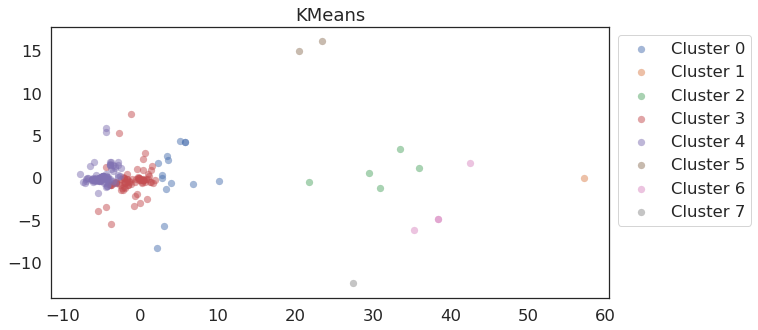

In [24]:
from sklearn.cluster import KMeans

#save KMeans instance, using 8 clusters
kmeans = KMeans(n_clusters=8)
#perform kmeans clustering on the normalised feature dataframe, transposed as we are clustering descriptors
kmeans.fit(normalised_features.transpose()) 
#save the results into a pandas dataframe
clusters = pandas.DataFrame({"Descriptor":normalised_features.columns,"Cluster":kmeans.labels_})

#plot the isomap
isomap_plot(normalised_features, clusters, "KMeans")

<div class="alert alert-warning" role="alert">
<b>Question:</b> Why do we need to transpose the normalised features dataset prior to using clustering?<br>
<b>Exercise:</b> Is the n_clusters suitable? Set n_clusters to other values to see the effects.<br>
<b>Exercise:</b> Run the cell above multiple times, does the clustering change dramatically? Why does it change at all?</div>

One method for feature selection could be to go through these clusters and select a single feature from each.

[Manifold Learning](Optional/ManifoldLearning.ipynb) is also another way of visually informing the user about relatedness of features, and can be used either in combination with clustering or standalone. 

Some clustering and manifold learning algorithms can take a precomputed distance, created using the functions above.

Creating the distance matrix - this can take a while.

In [33]:
#Create len(descriptors) * len(descriptors) matrix, all values are 0
m = [[0 for a in range(len(normalised_features.columns))] for b in range(len(normalised_features.columns))]


#create a list of integers, starting at 0 where each integer matches a descriptor.
#e.g. if there are 200 descriptors, n will be 0 to 200.
n = normalised_features.columns.tolist()

#convert the matrix into a dataframe - so we can save descriptor values
m = pandas.DataFrame(m)
#save the index and columns as the descriptor names
m.index = normalised_features.columns
m.columns = normalised_features.columns

#iterate through each descriptor
for a in n:
    #whilst we save one descriptor as X, iterate through all descriptors again as Y, to calculate distances between X and each Y
    for b in n:
        #save x descriptor values
        x = normalised_features[a]
        #save y descriptor values
        y = normalised_features[b]
        #calculate the distance using the function above
        distance = getDistance(x,y)
        #save the distance in the relevant location.
        m.loc[a,b] = distance

print("Distances calculated")

Distances calculated


In [34]:
#see the first 10 entries
m.head(10)

BalabanJ  BertzCT  Chi0  Chi0n  Chi0v  Chi1  Chi1n  Chi1v  Chi2n  \
BalabanJ      0.00     3.21  3.52   3.52   3.45  3.46   3.53   3.34   3.61   
BertzCT       3.21     0.00  1.48   1.69   1.66  1.39   1.77   1.62   1.98   
Chi0          3.52     1.48  0.00   1.00   1.56  0.98   1.35   1.56   1.92   
Chi0n         3.52     1.69  1.00   0.00   1.63  1.23   1.14   1.57   1.77   
Chi0v         3.45     1.66  1.56   1.63   0.00  1.34   1.55   1.17   1.75   
Chi1          3.46     1.39  0.98   1.23   1.34  0.00   1.23   1.42   1.79   
Chi1n         3.53     1.77  1.35   1.14   1.55  1.23   0.00   1.63   1.62   
Chi1v         3.34     1.62  1.56   1.57   1.17  1.42   1.63   0.00   1.66   
Chi2n         3.61     1.98  1.92   1.77   1.75  1.79   1.62   1.66   0.00   
Chi2v         3.37     1.67  1.70   1.73   1.45  1.68   1.79   1.17   1.62   

          Chi2v   ...     fr_quatN  fr_sulfide  fr_sulfonamd  fr_sulfone  \
BalabanJ   3.37   ...         2.42        2.57          2.49        2.38   
BertzCT    1.67   ...         1.36        1.50          1.42        1.31   
Chi0       1.70   ...         1.70        1.82          1.76        1.65   
Chi0n      1.73   ...         1.76        1.89          1.83        1.72   
Chi0v      1.45   ...         1.72        1.85          1.79        1.67   
Chi1       1.68   ...         1.73        1.85          1.80        1.68   
Chi1n      1.79   ...         1.83        1.97          1.90        1.78   
Chi1v      1.17   ...         1.63        1.75          1.68        1.57   
Chi2n      1.62   ...         1.98        2.12          2.05        1.93   
Chi2v      0.00   ...         1.60        1.72          1.65        1.54   

          fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiophene  \
BalabanJ               2.36          2.35         2.40          2.42   
BertzCT                1.30          1.29         1.33          1.35   
Chi0                   1.63          1.63         1.67          1.69   
Chi0n                  1.70          1.70         1.74          1.76   
Chi0v                  1.66          1.65         1.69          1.72   
Chi1                   1.67          1.66         1.70          1.72   
Chi1n                  1.77          1.76         1.81          1.83   
Chi1v                  1.56          1.56         1.60          1.62   
Chi2n                  1.92          1.91         1.96          1.98   
Chi2v                  1.54          1.53         1.57          1.59   

          fr_unbrch_alkane  fr_urea  
BalabanJ              2.90     2.35  
BertzCT               1.83     1.30  
Chi0                  2.13     1.63  
Chi0n                 2.19     1.70  
Chi0v                 2.14     1.65  
Chi1                  2.15     1.66  
Chi1n                 2.24     1.76  
Chi1v                 2.04     1.56  
Chi2n                 2.40     1.92  
Chi2v                 2.05     1.53  

[10 rows x 185 columns]

Let's just assert the distance metric formalities are met:
* D(x,x) = 0
* D(x,y) = D(y,x)
* D(x,y) + D(y,z) >= D(x,z)

In [36]:
#check that all are 0 or above
assert m.all().values.all() >= 0

#check all d(x,x) == 0
for a in n:
    #save the distance between descriptor X and descriptor X
    distance = m.loc[a,a] 
    assert distance == 0, "distance %(distance)f is not 0 (%(name)s)" % {"distance":distance,"name":desc.columns[a]}

#d(x,y) == d(y,x)        
for a in n:
    for b in n:
        #save the two distances, d(x,y) and d(y,x)
        distance1 = m.loc[a,b]
        distance2 = m.loc[b,a]
        assert distance1 == distance2, "Distance1 %(d1)f does not equal Distance 2 %(d2)f (X = %(a)s, Y = %(b)s)" % {"d1":distance1,"d2":distance2,"a":desc.columns[a],"b":desc.columns[b]}

#d(x,y) + d(y,z) >= d(x,z)
#we'll look at once example for this
X = normalised_features["BalabanJ"]
Y = normalised_features["BertzCT"]
Z = normalised_features["Chi0"]

#using debug, the getDistance function will print the equations
distance1 = getDistance(X,Y, True)
distance2 = getDistance(Y,Z, True)
distance3 = getDistance(X,Z, True)

assert distance1 + distance2 >= distance3, "D(X,Y)+D(Y,Z) >= D(X,Z)"

print("\n"+str(distance1+distance2)+" >= "+str(distance3)+"?")

#save the distance matrix to a pickle
m.to_pickle("../model_data/chembl21_features_drug_easy_train_distances.p")

3.21 = 2.305 + 1.242 - (2*0.167)
1.48 = 1.242 + 1.577 - (2*0.669)
3.52 = 2.305 + 1.577 - (2*0.181)

4.6899999999999995 >= 3.52?


## Further reading

For more information on the topics covered here:
    
1. [Feature selection in sklearn](http://scikit-learn.org/stable/modules/feature_selection.html)
2. [Mutual information for feature selection](https://www.sciencedirect.com/science/article/pii/S0167923612002291)


[Up](../Welcome.ipynb)<br> [Back](CrossValidation.ipynb) [Next](LinearModelling.ipynb)

---------------------------------------------------
Copyright STFC 2018